## Import libraries

In [1]:
import numpy as np
import pandas as pd
from os.path import join as opj
from fastdtw import fastdtw
from nilearn import datasets, plotting, surface
from nilearn.image import load_img, new_img_like
from scipy.spatial.distance import cdist, correlation

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Set paths & parameters

In [17]:
datadir = '../../../data/processed/'
figdir = '../../../paper/figs/'

# example voxel
sl_rad = 2
ex_x, ex_y, ex_z, ex_sub = (50, 57, 25, 4)

sns.set_context('paper')
mpl.rcParams['pdf.fonttype'] = 42
corrmat_cmap = plt.cm.bone_r
brain_cmap = plt.cm.hot

## Define functions

In [3]:
def kth_diag_indices(arr, k):
    row_ix, col_ix = np.diag_indices_from(arr)
    return row_ix[:-k], col_ix[k:]

## Load data

In [28]:
# video and example participant trajectories
video, recalls = np.load(opj(datadir, 'models_t100_v50_r10.npy'), allow_pickle=True)
p17_recall = recalls[-1]

# permutation-corrected searchlight results
zmap_video = load_img(opj(datadir, 'searchlight_video', 'zmap_video.nii.gz'))
zmap_recall = load_img(opj(datadir, 'searchlight_recall', 'zmap_recall.nii.gz'))

# MNI-space reference image
ref_img = load_img(opj(datadir, 'searchlight_video', 'ref_img.nii.gz'))

In [5]:
# example searchlight
ex_scan = load_img(opj(datadir, 'fMRI', f'sherlock_movie_s{ex_sub}.nii.gz')).dataobj
ex_searchlight = ex_scan[
    ex_x - sl_rad : ex_x + sl_rad + 1, 
    ex_y - sl_rad : ex_y + sl_rad + 1, 
    ex_z - sl_rad : ex_z + sl_rad + 1
]

# remove voxels masked for analysis
sl_mask = (ex_searchlight == 0).all(axis=3)
ex_searchlight[sl_mask] = np.nan
ex_searchlight = ex_searchlight.reshape(125, 1976)

## Warp recall model to TR time series

In [6]:
dist, path = fastdtw(video, p17_recall, dist=correlation)
vid_path = [i[0] for i in path]
rec_path = [i[1] for i in path]
p17_dtw = p17_recall[rec_path]

In [7]:
# video was untouched by dynamic time-warping
assert vid_path == list(range(video.shape[0]))

## Construct correlation matrices

In [8]:
vv_corrmat = 1 - cdist(video, video, 'correlation')
vr_corrmat = 1 - cdist(video, p17_recall, 'correlation')
vr_dtw_corrmat = 1 - cdist(video, p17_dtw, 'correlation')
# pandas corr handles nans
bb_corrmat = pd.DataFrame(ex_searchlight).corr().values

## Isolate proximal temporal correlations

In [9]:
diag_mask = np.zeros_like(vv_corrmat, dtype=bool)

for k in range(video.shape[0]):
    d = np.diag(vv_corrmat, k=k)
    if ~(d > 0).any():
        diag_limit = k
        break
        
print(f'diag limit: {diag_limit}')

diag limit: 238


In [25]:
# mask long-range temporal correlations
for k in range(1, diag_limit):
    ix = kth_diag_indices(diag_mask, k)
    diag_mask[ix] = True

vv_masked = np.copy(vv_corrmat)
vr_masked = np.copy(vr_dtw_corrmat)
bb_masked = np.copy(bb_corrmat)
vv_masked[~diag_mask] = vv_masked.min()
vr_masked[~diag_mask] = vr_masked.min()
bb_masked[~diag_mask] = bb_masked.min()

## Plot schematic

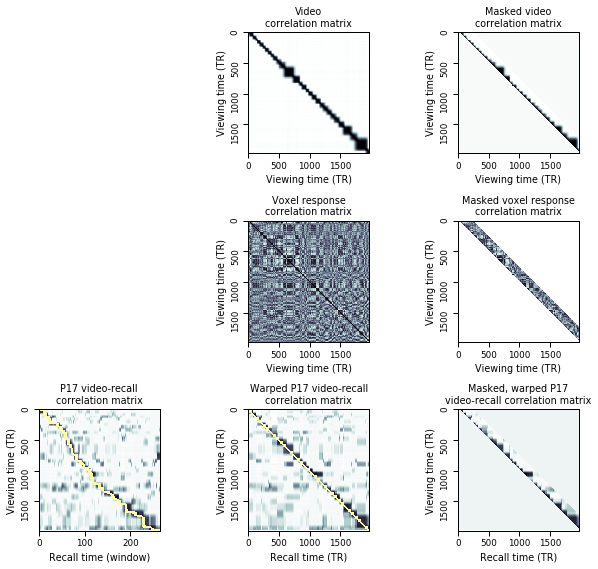

In [24]:
fig, (vid_ax, brain_ax, rec_ax) = plt.subplots(3, 3)
(v1, v2, v3), (b1, b2, b3), (r1, r2, r3) = vid_ax, brain_ax, rec_ax
fig.set_size_inches(9, 8)

v1.axis('off')

# video correlation matrix
v2 = sns.heatmap(vv_corrmat, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=v2)
v2.set_xlabel('Viewing time (TR)')
v2.set_ylabel('Viewing time (TR)')
v2.set_title('Video\ncorrelation matrix')
for _, spine in v2.spines.items():
    spine.set_visible(True)
v2.collections[0].remove()
v2.imshow(vv_corrmat, aspect='equal', cmap=corrmat_cmap)

# masked video correlation matrix
v3 = sns.heatmap(vv_masked, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=v3)
v3.set_xlabel('Viewing time (TR)')
v3.set_ylabel('Viewing time (TR)')
v3.set_title('Masked video\ncorrelation matrix')
for _, spine in v3.spines.items():
    spine.set_visible(True)
v3.collections[0].remove()
v3.imshow(vv_masked, aspect='equal', cmap=corrmat_cmap)

b1.axis('off')

# voxel response correlation matrix
b2 = sns.heatmap(bb_corrmat, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=-1, vmax=1, cbar=False, ax=b2)
b2.set_xlabel('Viewing time (TR)')
b2.set_ylabel('Viewing time (TR)')
b2.set_title('Voxel response\ncorrelation matrix')
for _, spine in b2.spines.items():
    spine.set_visible(True)
b2.collections[0].remove()
b2.imshow(bb_corrmat, aspect='equal', cmap=corrmat_cmap)

# masked voxel response correlation matrix
b3 = sns.heatmap(bb_masked, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=-1, vmax=1, cbar=False, ax=b3)
b3.set_xlabel('Viewing time (TR)')
b3.set_ylabel('Viewing time (TR)')
b3.set_title('Masked voxel response\ncorrelation matrix')
for _, spine in b3.spines.items():
    spine.set_visible(True)
b3.collections[0].remove()
b3.imshow(bb_masked, aspect='equal', cmap=corrmat_cmap)


# P17 video-recall correlation matrix
r1 = sns.heatmap(vr_corrmat, xticklabels=100, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=r1)
r1.set_xlabel('Recall time (window)')
r1.set_ylabel('Viewing time (TR)')
r1.set_title('P17 video-recall\ncorrelation matrix')
for _, spine in r1.spines.items():
    spine.set_visible(True)
r1.collections[0].remove()
r1.imshow(vr_corrmat, aspect=(vr_corrmat.shape[1] / vr_corrmat.shape[0]), cmap=corrmat_cmap)
for vid_ix, rec_ix in path:
    pt = patches.Rectangle((rec_ix, vid_ix), 1, 1, linewidth=2, edgecolor='#FFF9AE', facecolor='#FFF9AE', zorder=2)
    r1.add_patch(pt)
    
# P17 warped video-recall correlation matrix
r2 = sns.heatmap(vr_dtw_corrmat, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=r2)
r2.set_xlabel('Recall time (TR)')
r2.set_ylabel('Viewing time (TR)')
r2.set_title('Warped P17 video-recall\ncorrelation matrix')
for _, spine in r2.spines.items():
    spine.set_visible(True)
r2.collections[0].remove()
r2.imshow(vr_dtw_corrmat, aspect='equal', cmap=corrmat_cmap)
for i in range(1976):
    pt = patches.Rectangle((i, i), 1, 1, linewidth=2, edgecolor='#FFF9AE', facecolor='#FFF9AE', zorder=2)
    r2.add_patch(pt)
    
# P17 masked warped video-recall correlation matrix
r3 = sns.heatmap(vr_masked, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=r3)
r3.set_xlabel('Recall time (TR)')
r3.set_ylabel('Viewing time (TR)')
r3.set_title('Masked, warped P17\nvideo-recall correlation matrix')
for _, spine in r3.spines.items():
    spine.set_visible(True)
r3.collections[0].remove()
r3.imshow(vr_masked, aspect='equal', cmap=corrmat_cmap)

plt.subplots_adjust(wspace=.45, hspace=.75)
plt.tight_layout()
# plt.savefig(opj(figdir, 'brain_corrmats.pdf'), dpi=1000)
plt.show()

## Plot searchlight maps

In [59]:
zvals_vid = np.array(zmap_video.dataobj)
zvals_rec = np.array(zmap_recall.dataobj)

zvals_combined = np.zeros_like(zvals_vid)
zvals_combined[zvals_vid != 0] = 1
zvals_combined[zvals_rec != 0] = 2
zvals_combined[(zvals_rec != 0) & (zvals_vid != 0)] = 3
zmap_combined = new_img_like(ref_img, zvals_combined)

In [78]:
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
vid_texture_pr = surface.vol_to_surf(zmap_combined, fsaverage.pial_right, radius=0)
vid_texture_pl = surface.vol_to_surf(zmap_combined, fsaverage.pial_left, radius=0)

In [81]:
vid_texture_pl.mean()

0.01222871776964413

In [68]:
brain_cmap = mpl.colors.ListedColormap(['red', 'blue', 'purple'], N=3)

In [ ]:
brain_cmap.

In [69]:
cnorm = mpl.colors.BoundaryNorm([0, 1, 2, 3], brain_cmap.N, clip=True)

-0.8834487217202357

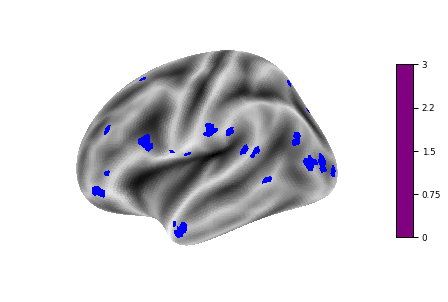

In [80]:
plotting.plot_surf_stat_map(fsaverage.infl_left, vid_texture_pl, hemi='left', view='lateral', 
                             bg_map=fsaverage.sulc_left, cmap=brain_cmap, threshold=.01, vmax=3, norm=cnorm)
plt.show()

# plotting.plot_surf_stat_map(fsaverage.infl_right, vid_texture_pr, hemi='right', view='lateral', 
#                              bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, vmax=3)
# plt.show()

# plotting.plot_surf_stat_map(fsaverage.infl_left, vid_texture_pl, hemi='left', view='medial', 
#                             bg_map=fsaverage.sulc_left, cmap=brain_cmap, threshold=.01, vmax=3)
# plt.show()

# plotting.plot_surf_stat_map(fsaverage.infl_right, vid_texture_pr, hemi='right', view='medial', 
#                              bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, vmax=3)
# plt.show()